In [1]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, AveragePooling2D,Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
import PIL

In [2]:
BATCH_SIZE = 64
IMG_HEIGHT = 180
IMG_WIDTH = 180
VAL_SPLIT = 0.2
SEED = 157
LABELS = 'binary'
DATA_PATH = '/kaggle/input/cat-vs-dogs'

In [3]:
animals = list(os.walk('/kaggle/input/cat-vs-dogs')) 

In [4]:
label_names = animals[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'dog': 0, 'cat': 1}


In [5]:
def dataset(path):
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] 

        for file in (os.listdir(os.path.join(path, folder, folder))):
            path_of_file = os.path.join(os.path.join(path, folder, folder), file)
            # print(path_of_file)
            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('/kaggle/input/cat-vs-dogs')
images, labels = shuffle(images, labels)

100%|██████████| 2/2 [00:36<00:00, 18.44s/it]


In [6]:
images.shape

(5364, 180, 180, 3)

In [7]:
labels[0]

0

In [8]:
# prove that it has been scaled
images[0].max()

1.0

In [9]:
size = len(images)
point = int(size*(1-VAL_SPLIT))
train_image = images[0:point+1]
train_label = labels[0:point+1]
val_image = images[point+1:size]
val_label = labels[point+1:size]
print(len(train_image) / size)
print(len(val_image) / size)

0.8001491424310216
0.19985085756897839


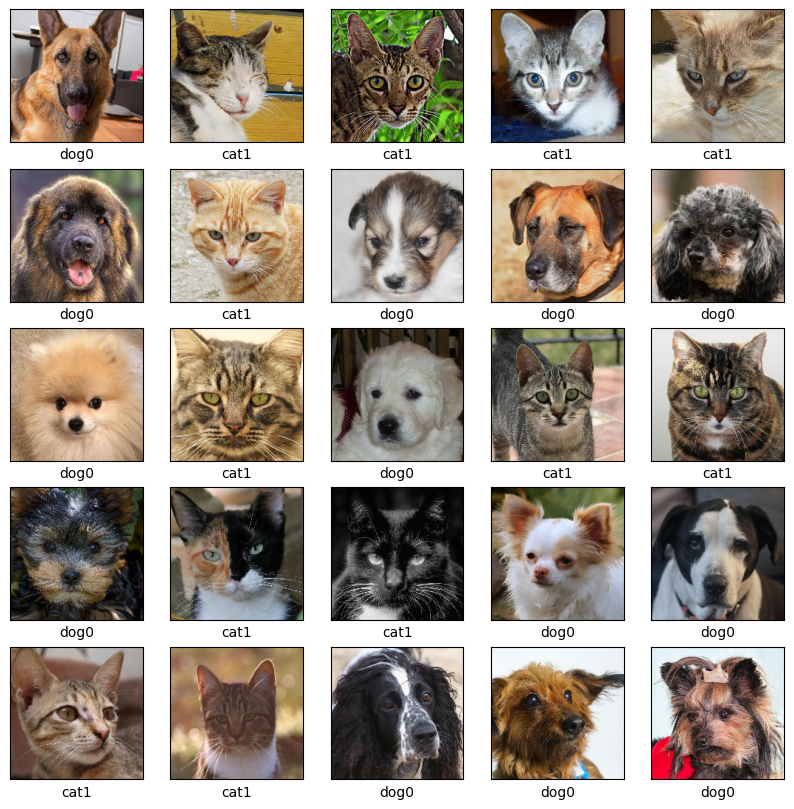

In [10]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[i]
    plt.xlabel(str(label_names[labels[i]] + str(labels[i])))
    plt.imshow(data);

In [11]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False, # Not including the Dense Layer
    input_shape = (IMG_HEIGHT,IMG_WIDTH,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
conv_base.trainable = False
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(120,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(images, labels, epochs=5, validation_data=(val_image, val_label))

Epoch 1/5


I0000 00:00:1733556948.628789      74 service.cc:145] XLA service 0x7aa2380052f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733556948.628843      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733556948.628847      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/168 ━━━━━━━━━━━━━━━━━━━━ 45:58 17s/step - accuracy: 0.5000 - loss: 0.8742

I0000 00:00:1733556963.202351      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


168/168 ━━━━━━━━━━━━━━━━━━━━ 53s 221ms/step - accuracy: 0.9116 - loss: 0.2019 - val_accuracy: 0.9981 - val_loss: 0.0039
Epoch 2/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.9919 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 3/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.9967 - loss: 0.0103 - val_accuracy: 1.0000 - val_loss: 5.9405e-04
Epoch 4/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.9971 - loss: 0.0090 - val_accuracy: 0.9991 - val_loss: 0.0015
Epoch 5/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9937 - loss: 0.0177 - val_accuracy: 1.0000 - val_loss: 1.1654e-04


In [15]:
model.save('PetNet.h5')

In [16]:
y_pred = model.predict(val_image) >= 0.5

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step


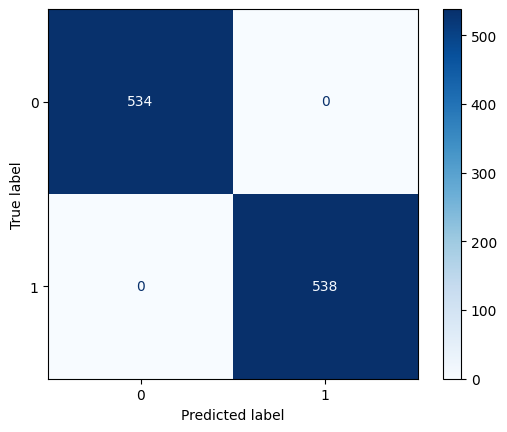

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_pred, val_label)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

168/168 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step


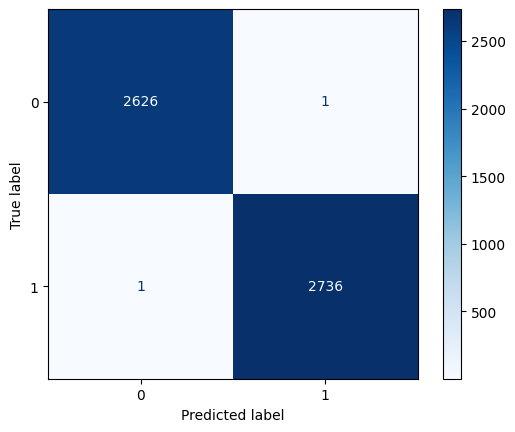

In [18]:
y_pred = model.predict(images) >= 0.5
cm = confusion_matrix(y_pred, labels)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

In [19]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

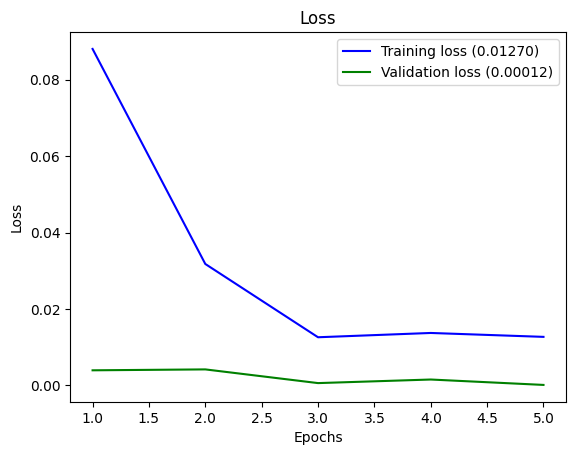

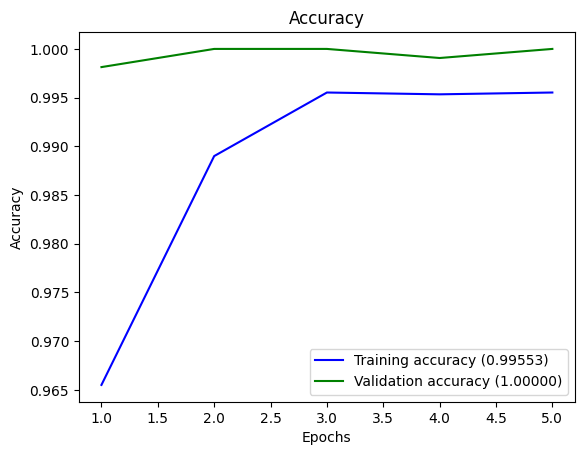

In [20]:
plot_history(history)